In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import pandas as pd
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import matplotlib
import matplotlib.pyplot as plt

#Load model
model_name = 'res_cnn_03_11_18_54' 
model = tf.keras.models.load_model("./data/models/"+model_name)

C:\Users\illew\anaconda3\envs\tf-gpu-hardness\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


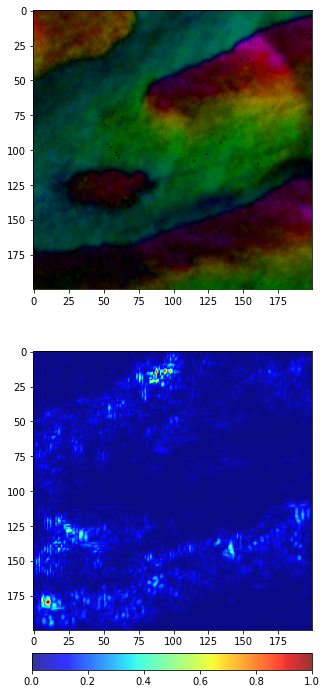

In [2]:
# Visualize Saliency Maps -----------------------------------------------------------------------------

#Pick image to visualize activations for
image_number = 300 

# Setting Up Image Data --------------------------------------------------------------

dfin=pd.read_csv("./testdatakey_0425.csv", encoding='utf-8')
imagedirectory="./testdata_0425/images"
imagelocation=[]
hardnessarray=[]
for filename in os.listdir(imagedirectory):
    imagelocation.append(imagedirectory+"/"+str(filename))
    hardness_value=filename.split("_")[0]
    hardnessarray.append(float(hardness_value))
dfin["hardness"]=hardnessarray
dfin["image_location"]=imagelocation

imageloc=dfin["image_location"][image_number]
img = image.load_img(imageloc)
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis = 0)
images = tf.Variable(img, dtype=float)

# Saliency Mapping -------------------------------------------------------------------

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1] 
    loss = pred[0][class_idxs_sorted[0]]
    
grads = np.array(tape.gradient(loss, images))
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_-arr_min)/(arr_max-arr_min+1e-18)

# Plotting figures -------------------------------------------------------------------

fig, axes = plt.subplots(2,1,figsize=(5,11.5))
img=img.squeeze()
axes[0].imshow(img)
axes[1].imshow(grad_eval, cmap="jet", alpha=0.8)
cbar_ax = fig.add_axes([0.12, 0.08, 0.78, 0.02])
fig.colorbar(axes[1].imshow(grad_eval, cmap="jet", alpha=0.8), orientation='horizontal', cax=cbar_ax)


In [2]:
# Visualize Saliency Distributions ----------------------------------------------------

saliency_list=[]
value_list=[]
hue_list=[]
for image_number in range(333):
    
    # Setting Up Image Data --------------------------------------------------------------
    dfin=pd.read_csv("./testdatakey_0425.csv", encoding='utf-8')
    imagedirectory="./testdata_0425/images"
    imagelocation=[]
    hardnessarray=[]
    for filename in os.listdir(imagedirectory):
        imagelocation.append(imagedirectory+"/"+str(filename))
        hardness_value=filename.split("_")[0]
        hardnessarray.append(float(hardness_value))
    dfin["hardness"]=hardnessarray
    dfin["image_location"]=imagelocation

    imageloc=dfin["image_location"][image_number]
    img = image.load_img(imageloc)
    img_array = image.img_to_array(img)
    img = img_array/255
    img = np.expand_dims(img, axis = 0)
    images = tf.Variable(img, dtype=float)

    # Saliency Mapping -------------------------------------------------------------------
    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1] 
        loss = pred[0][class_idxs_sorted[0]]

    grads = np.array(tape.gradient(loss, images))
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_-arr_min)/(arr_max-arr_min+1e-18)

    # Value Mapping --------------------------------------------
    Sample_Hue = matplotlib.colors.rgb_to_hsv(img_array)[:,:,0]*(180)-90 #"In polarization plane" phi Spherical Coordinates, Degrees
    Sample_Val = matplotlib.colors.rgb_to_hsv(img_array)[:,:,2]/255*(90) #"Out polarization plane" theta Spherical Coordinates, Degrees
    
    #List Constructing -------------------------------------------
    for i in range(grad_eval.shape[0]):
        for j in range(grad_eval.shape[1]):
            saliency_list.append(grad_eval[i,j])
            hue_list.append(Sample_Hue[i,j])
            value_list.append(Sample_Val[i,j])


In [3]:
#Convert Hue(phi) and Value(theta) Spherical coordinates (degrees) to Cartesian
phi_orientations = np.asarray(hue_list)/180*np.pi #-90 to 90
the_orientations = np.asarray(value_list)/180*np.pi
x_ori = np.absolute(np.sin(the_orientations)*np.cos(phi_orientations))
y_ori = np.sin(the_orientations)*np.sin(phi_orientations)
z_ori = np.absolute(np.cos(the_orientations))

#Rotate coordinates to in-plane/out-plane with respect to the sample, 
#60 degrees counterclockwise about the x axis, due to PIC map polarization offset
rotation = 60/180*np.pi
x_prime = x_ori
y_prime = y_ori*np.cos(rotation) - z_ori*np.sin(rotation)
z_prime = y_ori*np.sin(rotation) + z_ori*np.cos(rotation)

#Flip to positive domain
for i in range(len(z_prime)):
    if z_prime[i]<0:
        z_prime[i]*=-1 
        y_prime[i]*=-1
        x_prime[i]*=-1

#Convert back to spherical coordinates in degrees    
phi_prime = np.arctan(y_prime/(x_prime+0.0001))/np.pi*180    
the_prime = np.arccos(z_prime)/np.pi*180

shv_df = pd.DataFrame()
shv_df['saliency']=saliency_list
shv_df['hue']=hue_list
shv_df['value']=value_list
shv_df['x_ori']=x_ori
shv_df['y_ori']=y_ori
shv_df['z_ori']=z_ori
shv_df['phi_prime']=phi_prime
shv_df['the_prime']=the_prime


In [4]:
print('saliency', min(shv_df['saliency']), max(shv_df['saliency']))
print('hue (d)', min(shv_df['hue']), max(shv_df['hue']))
print('value (d)', min(shv_df['value']), max(shv_df['value']))#=value_list
print('x',min(shv_df['x_ori']), max(shv_df['x_ori']))#=x_ori
print('y',min(shv_df['y_ori']), max(shv_df['y_ori']))#=y_ori
print('z',min(shv_df['z_ori']), max(shv_df['z_ori']))#=z_ori
print('x\'',min(x_prime), max(x_prime))#=x_ori
print('y\'',min(y_prime), max(y_prime))#=y_ori
print('z\'',min(z_prime), max(z_prime))#=z_ori
print('phi\'',min(shv_df['phi_prime']), max(shv_df['phi_prime']))#=phi_prime
print('theta\'',min(shv_df['the_prime']), max(shv_df['the_prime']))#=the_prime


saliency 0.0 1.0
hue (d) -90.0 89.8800048828125
value (d) 0.0 90.0
x -0.9999778270721436 0.9999977350234985
y -0.9999278783798218 0.9999974966049194
z 4.371138828673793e-08 1.0
x' -0.9999778 0.99999774
y' -1.0 0.999981
z' 0.0 0.9999849
phi' -89.99427032470703 89.99427032470703
theta' 0.3146578073501587 90.0


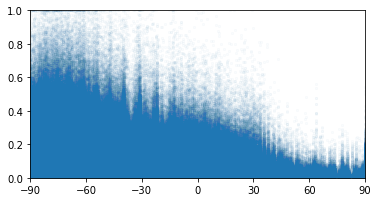

In [13]:
#Saliency vs Phi
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(aspect=90, adjustable='box')
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_ylim(0, 1)
ax.set_xlim(-90, 90)
plt.scatter(shv_df['phi_prime'], shv_df['saliency'], alpha=0.02, s=5)

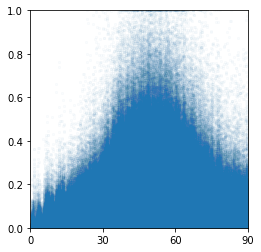

In [14]:
#Saliency vs theta
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(aspect=90, adjustable='box')
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_ylim(0, 1)
ax.set_xlim(0, 90)
plt.scatter(shv_df['the_prime'], shv_df['saliency'], alpha=0.02, s=5)

(array([6.97198e+05, 5.17091e+05, 5.15477e+05, 6.39524e+05, 5.65019e+05,
        4.58875e+05, 5.08427e+05, 5.48883e+05, 4.45315e+05, 4.44898e+05,
        4.47360e+05, 3.98432e+05, 3.73959e+05, 4.46733e+05, 3.92225e+05,
        3.62424e+05, 3.25731e+05, 3.60512e+05, 3.13395e+05, 2.37359e+05,
        3.02324e+05, 3.12194e+05, 2.11762e+05, 2.08850e+05, 2.63132e+05,
        2.09421e+05, 1.45663e+05, 1.46404e+05, 2.00208e+05, 1.98135e+05,
        1.38618e+05, 1.21919e+05, 1.40017e+05, 1.42895e+05, 1.29455e+05,
        1.00732e+05, 7.75780e+04, 9.26460e+04, 1.09850e+05, 9.98570e+04,
        1.04096e+05, 8.29010e+04, 7.55320e+04, 6.35620e+04, 5.22110e+04,
        4.73250e+04, 5.14300e+04, 3.93770e+04, 3.87270e+04, 3.76470e+04,
        3.40940e+04, 2.93020e+04, 2.81310e+04, 2.77500e+04, 2.53020e+04,
        2.31730e+04, 2.00270e+04, 1.91540e+04, 1.81860e+04, 1.60790e+04,
        1.31390e+04, 1.22160e+04, 7.41500e+03, 6.08000e+03, 6.76300e+03,
        8.06800e+03, 4.63000e+03, 5.16100e+03, 4.79

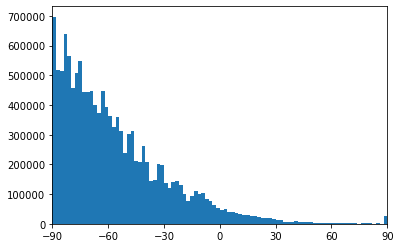

In [15]:
#Frequency of Phi
phi_hist=np.histogram(shv_df['phi_prime'], bins=90)
phi_hist_scaled=phi_hist[0]/np.min(phi_hist[0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_xlim(-90, 90)
plt.hist(shv_df['phi_prime'], bins=90) #(180)

(array([  1802.,   4024.,   3958.,  14883.,   9587.,  22488.,  32725.,
         28852.,  45439.,  56959.,  65395.,  86539., 120924., 121318.,
        181365., 226972., 253462., 324973., 374788., 350167., 400346.,
        448733., 448485., 470376., 579279., 529084., 586053., 559619.,
        548936., 549642., 601298., 528933., 427828., 528983., 430944.,
        431792., 418006., 367130., 362636., 315482., 288214., 297770.,
        314770., 269674., 289367.]),
 array([ 0.3146578,  2.3076653,  4.300673 ,  6.2936807,  8.286688 ,
        10.2796955, 12.272703 , 14.265711 , 16.258718 , 18.251726 ,
        20.244734 , 22.237741 , 24.23075  , 26.223757 , 28.216764 ,
        30.209772 , 32.202778 , 34.195786 , 36.188793 , 38.1818   ,
        40.17481  , 42.167816 , 44.160824 , 46.15383  , 48.14684  ,
        50.139847 , 52.132854 , 54.125862 , 56.11887  , 58.111877 ,
        60.104885 , 62.097893 , 64.090904 , 66.08391  , 68.07692  ,
        70.06992  , 72.062935 , 74.05594  , 76.04895  , 78.04

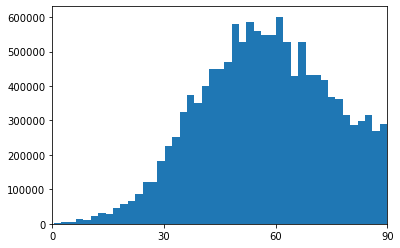

In [16]:
#Frequency of theta
the_hist=np.histogram(shv_df['the_prime'],bins=45)
the_hist_scaled=the_hist[0]/np.min(the_hist[0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_xlim(0, 90)
plt.hist(shv_df['the_prime'],bins=45) #90

In [10]:
#Saliency/Frequency
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [11]:
saliency_scaled=[]
for i in range(len(shv_df['phi_prime'])):
    index = find_nearest(phi_hist[1],shv_df['phi_prime'][i])
    saliency_scaled.append(shv_df['saliency'][i]/phi_hist_scaled[index-1])
shv_df['phi_saliency_scaled'] = saliency_scaled/np.max(saliency_scaled)

saliency_scaled=[]
for i in range(len(shv_df['the_prime'])):
    index = find_nearest(the_hist[1],shv_df['the_prime'][i])
    saliency_scaled.append(shv_df['saliency'][i]/the_hist_scaled[index-1])
shv_df['the_saliency_scaled'] = saliency_scaled/np.max(saliency_scaled)


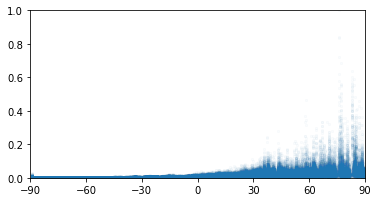

In [22]:
#Relative Saliency of phi
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(aspect=90, adjustable='box')
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_ylim(0, 1)
ax.set_xlim(-90, 90)
plt.scatter(phi_prime_, shv_df['phi_saliency_scaled'], alpha=0.02, s=5)

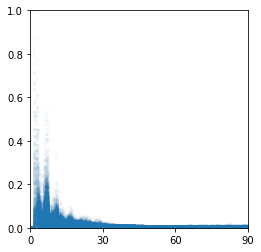

In [23]:
#Relative Saliency of theta
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(aspect=90, adjustable='box')
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_ylim(0, 1)
ax.set_xlim(0, 90)
plt.scatter(shv_df['the_prime'], shv_df['the_saliency_scaled'], alpha=0.02, s=5)